# Post processing and visualizing mandyoc data

The following notebook allows the user to visualize a given mandyoc output (e.g.: `'temperature'`, `'strain_rate'`, `'lithology'`, etc) according to a given number of time instants (e.g.: `instants = [0, 10, 20, 30]` Myr. `len(instants)` must be >= 2.

For a given instant in the `instants` the script will find the closest time step to this instant and plot the respective output.

In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import os
import sys
import pylab as pl
import xarray as xr
import pymp
import mpl_toolkits.axisartist
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import string

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

sys.path.insert(0, f"{machine_path}/opt/scripts/functions")
from mandyocIO import read_datasets, change_dataset, plot_property, find_nearest, plot_tracked_particles, _extract_interface

# How to plot

## In the following cell, you must inform:
 - The path to your `scenario` without `/OS_home/username` because this is collected by `machine_path`.
     - Ex.: `/mandyoc/experiments/my_experiment/`
 - The mandyoc property `prop` that you want to visualize uncommenting one the commented options.
     - `prop = 'lithology'` is the default.
 - The values in list `instants` containing the instants that you want to visualize.
     - Ex: `instants = [0, 10, 20, 30]` #Myr

In [4]:
#Set scenario path
local = False
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo'
    model_path = f"/Volumes/{external_media}"

# v = 1
v = 2

if(v==1):
    scenarios = [
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc10_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v1/RFT_lithoramp_DT230_Tp1350oC_v1_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v1/RFT_lithoramp_DT230_Tp1350oC_v1_Clc10_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v1/RFT_DT230_Tp1350oC_crust40km_v1_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v1/RFT_DT230_Tp1350oC_crust40km_v1_Clc10_checkered_false",
                
                ]
    
if(v==2):
    scenarios = [
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc10_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v2/RFT_lithoramp_DT230_Tp1350oC_v2_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v2/RFT_lithoramp_DT230_Tp1350oC_v2_Clc10_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v2/RFT_DT230_Tp1350oC_crust40km_v2_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v2/RFT_DT230_Tp1350oC_crust40km_v2_Clc10_checkered_false",
                
                ]
read_ascii = True # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
save_images = True # Generate and save all the possible images
save_big_dataset = False#True
plot_isotherms = True
# plot_melt = True
plot_melt = False

if(plot_isotherms or plot_melt):
    clean_plot=False
else:
    clean_plot = True

datasets = [#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'density',
            'radiogenic_heat',
            'pressure',
            'strain',
            'strain_rate',### Read ascii outputs and save them as xarray.Datasets,
            'surface',
            'temperature',
            'viscosity'
            ]# Read data and convert them to xarray.Dataset

properties = [#Properties from mandyoc. Comment/uncomment to select which ones you would like to plot
            #  'density',
#              'radiogenic_heat',
             'lithology',
#              'pressure',
            #  'strain',
            #  'strain_rate',
            #  'temperature',
            #  'temperature_anomaly',
            #  'surface',
            #  'viscosity'
             ]

# Read ascii outputs and save them as xarray.Datasets

new_datasets = change_dataset(properties, datasets)

to_remove = []
remove_density=False
if ('density' not in properties): #used to plot air/curst interface
        properties.append('density')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('density')
        # remove_density=True

if ('surface' not in properties): #used to plot air/curst interface
        properties.append('surface')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('surface')
        # remove_density=True

if (plot_isotherms): #add datasets needed to plot isotherms
    if ('temperature' not in new_datasets):
        properties.append('temperature')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('temperature')

# print(f"newdataset4 {new_datasets}")

if (plot_melt): #add datasets needed to plot melt fraction
    if ('pressure' not in new_datasets):
        properties.append('pressure')
    if ('temperature' not in new_datasets):
        properties.append('temperature')
    new_datasets = change_dataset(properties, datasets)

    #removing the auxiliary datasets to not plot
    to_remove.append('pressure')
    to_remove.append('temperature')

if(clean_plot): #a clean plot
    new_datasets = change_dataset(properties, datasets)

for item in to_remove:
    properties.remove(item)

dataset0 = read_datasets(scenarios[0], new_datasets)
dataset1 = read_datasets(scenarios[1], new_datasets)
dataset2 = read_datasets(scenarios[2], new_datasets)
dataset3 = read_datasets(scenarios[3], new_datasets)
dataset4 = read_datasets(scenarios[4], new_datasets)
dataset5 = read_datasets(scenarios[5], new_datasets)

# Normalize velocity values
if ("velocity_x" and "velocity_z") in dataset0.data_vars:
    v_max = np.max((dataset0.velocity_x**2 + dataset0.velocity_z**2)**(0.5))    
    dataset0.velocity_x[:] = dataset0.velocity_x[:] / v_max
    dataset0.velocity_z[:] = dataset0.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset1.data_vars:
    v_max = np.max((dataset1.velocity_x**2 + dataset1.velocity_z**2)**(0.5))    
    dataset1.velocity_x[:] = dataset1.velocity_x[:] / v_max
    dataset1.velocity_z[:] = dataset1.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset2.data_vars:
    v_max = np.max((dataset2.velocity_x**2 + dataset2.velocity_z**2)**(0.5))    
    dataset2.velocity_x[:] = dataset2.velocity_x[:] / v_max
    dataset2.velocity_z[:] = dataset2.velocity_z[:] / v_max


Nx = int(dataset0.nx)
Nz = int(dataset0.nz)
Lx = float(dataset0.lx)
Lz = float(dataset0.lz)

x = np.linspace(0, Lx/1000.0, Nx)
z = np.linspace(Lz/1000.0, 0, Nz)
xx, zz  = np.meshgrid(x, z)

print(f"\n{dataset0.info}")

trackdataset0 = xr.open_dataset(f"{scenarios[0]}/_track_xzPT_all_steps.nc")
trackdataset1 = xr.open_dataset(f"{scenarios[1]}/_track_xzPT_all_steps.nc")
trackdataset2 = xr.open_dataset(f"{scenarios[2]}/_track_xzPT_all_steps.nc")
trackdataset3 = xr.open_dataset(f"{scenarios[3]}/_track_xzPT_all_steps.nc")
trackdataset4 = xr.open_dataset(f"{scenarios[4]}/_track_xzPT_all_steps.nc")
trackdataset5 = xr.open_dataset(f"{scenarios[5]}/_track_xzPT_all_steps.nc")


<bound method Dataset.info of <xarray.Dataset> Size: 2GB
Dimensions:      (x: 1601, z: 401, time: 101)
Coordinates:
  * x            (x) float64 13kB 0.0 1e+03 2e+03 ... 1.599e+06 1.6e+06
  * z            (z) float64 3kB -4e+05 -3.99e+05 -3.98e+05 ... -1e+03 0.0
  * time         (time) float64 808B 0.0 0.5 1.0 1.5 ... 38.53 38.98 39.34 39.68
    step         (time) int32 404B 0 100 200 300 400 ... 9700 9800 9900 10000
Data variables:
    strain       (time, x, z) float64 519MB ...
    density      (time, x, z) float64 519MB ...
    surface      (time, x) float64 1MB ...
    temperature  (time, x, z) float64 519MB ...
Attributes: (12/95)
    nx:                                1601
    nz:                                401
    lx:                                1600000.0
    lz:                                400000.0
    multigrid:                         1
    solver:                            direct
    ...                                ...
    temperature_units:                 C

Symmetries_v2_lithology


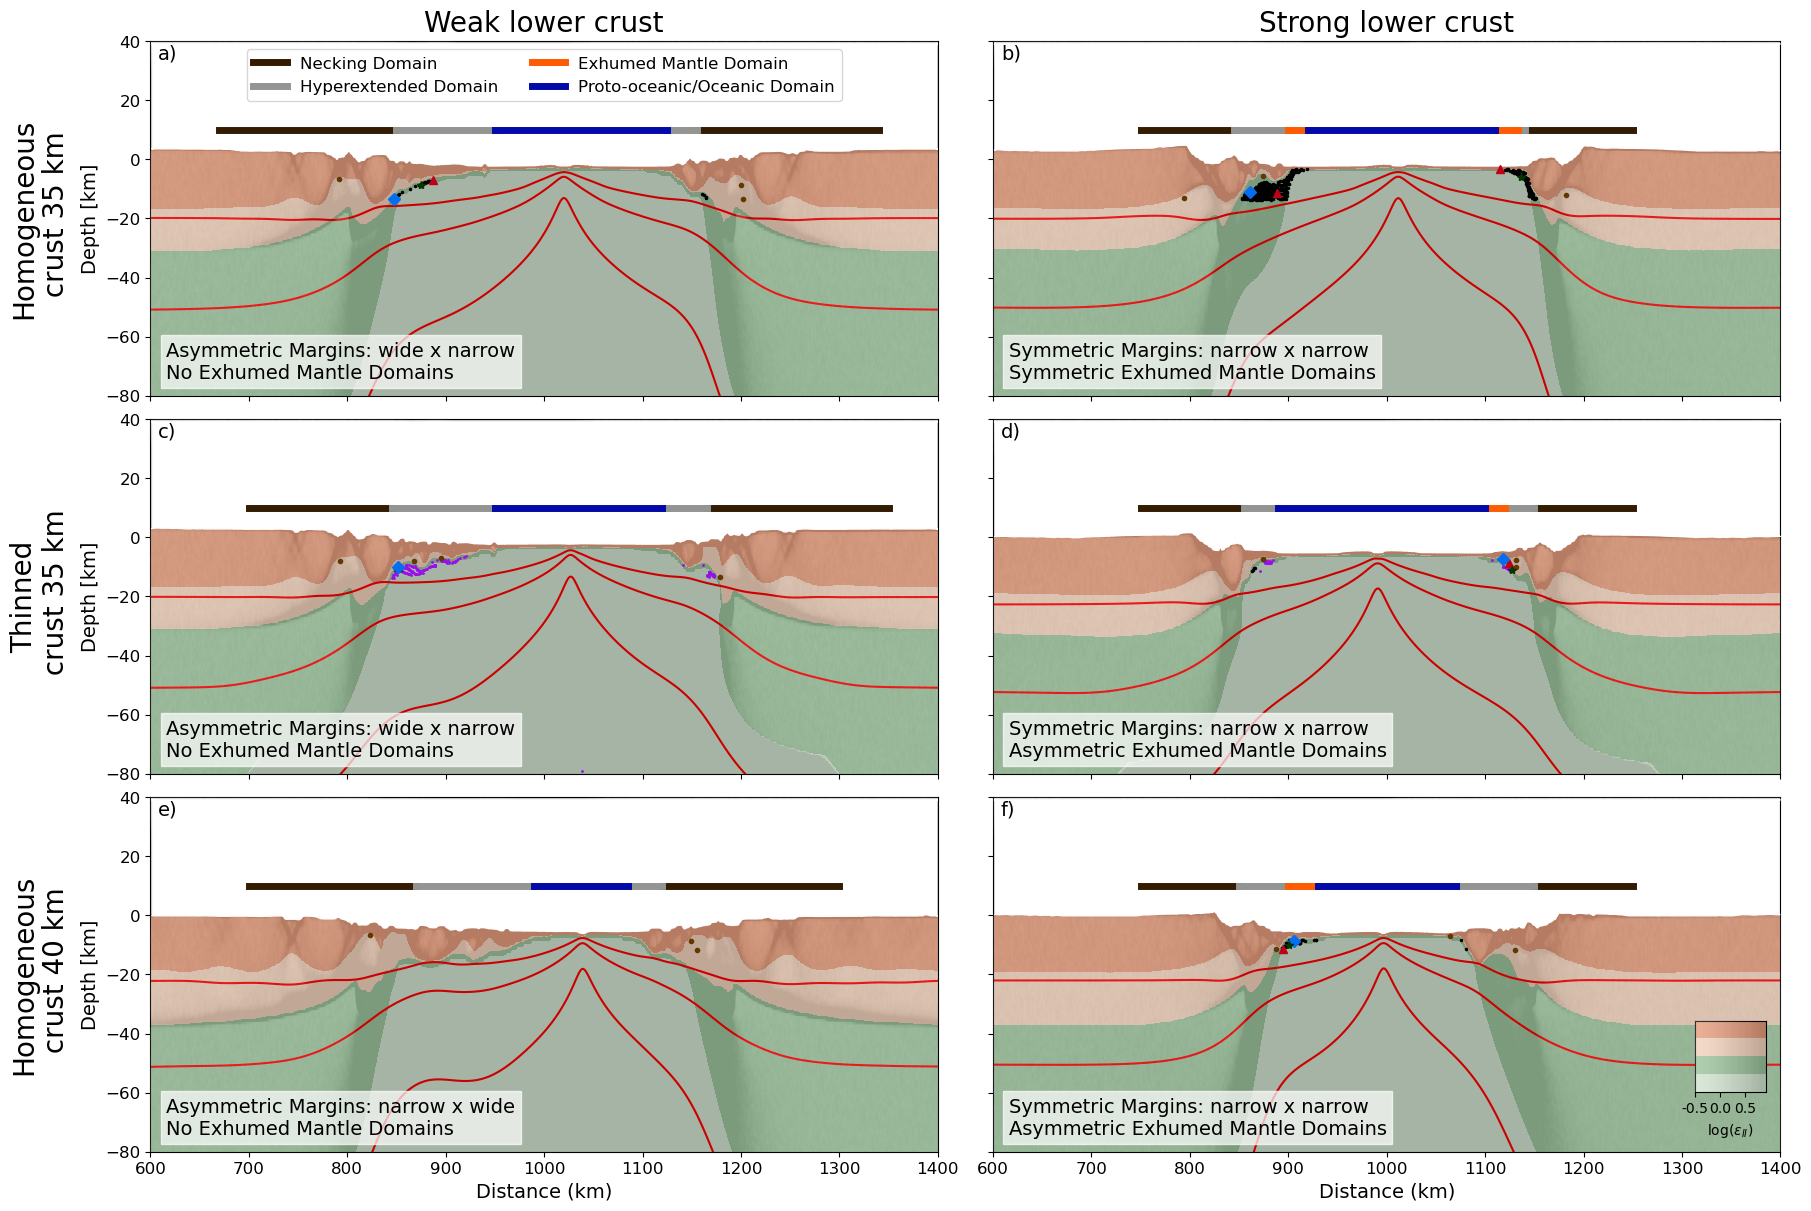

In [5]:
##############################################################################################################
#Set mandyoc property

# prop = 'density'
# prop = 'heat'
prop = 'lithology'
# prop = 'pressure'
# prop = 'strain'
# prop = 'strain_rate'
# prop = 'temperature'
# prop = 'temperature_anomaly'
# prop = 'viscosity'
# prop = 'surface'

# instants = [0, 10., 20., 30.] #Myr

# instants = [34.59, 27.01, 30.54, 33.14] #Myr
instants = [40, 40, 40, 40, 40, 40] if v==1 else [20, 20, 20, 20, 20, 20] #Myr


datasets_list = [dataset0, dataset1, dataset2, dataset3, dataset4, dataset5]
trackdatasets_list = [trackdataset0, trackdataset1, trackdataset2, trackdataset3, trackdataset4, trackdataset5]

plt.close('all')

fig_height = (3.0/2.0)*(len(instants) + 2) #6 minimum
fig = plt.figure(figsize=(18, fig_height), constrained_layout=True)

mosaic = """
         AB
         CD
         EF
         """
axs = fig.subplot_mosaic(mosaic, gridspec_kw={'height_ratios':[0.5,
                                                               0.5,
                                                               0.5,
                                                              ]
                                             }
                        )

alphabet = list(string.ascii_uppercase)
axs_idxs = np.asarray(alphabet[0: len(scenarios)]) #starting at A subplot
idxs_aux = axs_idxs.reshape(int(len(scenarios)/2),2)

xlims = [600, 1400]
ylims = [-80, 40]
topo_from_density = True
# topo_from_density = False
plot_other_particles = True
# plot_other_particles = False

for instant, dataset, trackdataset, ax_idx in zip(instants, datasets_list, trackdatasets_list, axs_idxs):
    idx = find_nearest(dataset.time, instant)
    plot_colorbar = True if ax_idx == axs_idxs[-1] else False

    plot_property(dataset.isel(time=idx), prop, xlims, ylims, scenarios[0],
             fig,
             axs[ax_idx],
             print_time=False,
             plot_isotherms = plot_isotherms,
             topo_from_density=topo_from_density,
             plot_particles = False,
             particle_size = 0.2,
             particle_marker = ".",
             ncores = 20,
            #  step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=plot_colorbar,
             bbox_to_anchor=(0.9,#horizontal position respective to parent_bbox or "loc" position
                            0.15,# vertical position
                            0.09,# width
                            0.2),
             # plot_melt = plot_melt,
             # melt_method = melt_method,
            )
    plot_tracked_particles(trackdataset, axs[ax_idx], idx,  plot_other_particles=plot_other_particles, color_other_particles='xkcd:black', size_other_particles=3)
    
    # axs[ax_idx].plot([0, Lx/1000.0], [-35,-35], 'k-', lw=1, zorder=100)
    # axs[ax_idx].plot([0, Lx/1000.0], [-10,-10], 'k-', lw=1, zorder=100)
    # axs[ax_idx].plot([0, Lx/1000.0], [-5,-5], 'k-', lw=1, zorder=100)
    # axs[ax_idx].plot([0, Lx/1000.0], [-2,-2], 'k-', lw=1, zorder=100)
    # axs[ax_idx].grid()

    # Nx = int(dataset.nx)
    # Nz = int(dataset.nz)
    # Lx = float(dataset.lx)
    # Lz = float(dataset.lz)

    # x = np.linspace(0, Lx/1000.0, Nx)
    # z = np.linspace(-Lz/1000.0, 0, Nz)
    # Z = np.linspace(-Lz/1000.0, 0, 8001) #zi

    # h_air = 40.0
    # Rhoi = dataset.isel(time=idx).density.values.T
    # topography_interface = _extract_interface(z, Z, Nx, Rhoi, 200.) + h_air
    # lower_interface = _extract_interface(z, Z, Nx, Rhoi, 2900.) + h_air
    
    # crustal_thickness = -np.abs(lower_interface - topography_interface)
    # axs[ax_idx].plot(x, crustal_thickness, 'k--', lw=1, zorder=100)

fsize = 14
##########################
#Set plot details
##########################
#Titles
xpos = 0.01
ypos = 0.95
axs['A'].text(xpos, ypos, f"a)", transform=axs['A'].transAxes, fontsize=fsize, zorder=60)
axs['B'].text(xpos, ypos, f"b)", transform=axs['B'].transAxes, fontsize=fsize, zorder=60)
axs['C'].text(xpos, ypos, f"c)", transform=axs['C'].transAxes, fontsize=fsize, zorder=60)
axs['D'].text(xpos, ypos, f"d)", transform=axs['D'].transAxes, fontsize=fsize, zorder=60)
axs['E'].text(xpos, ypos, f"e)", transform=axs['E'].transAxes, fontsize=fsize, zorder=60)
axs['F'].text(xpos, ypos, f"f)", transform=axs['F'].transAxes, fontsize=fsize, zorder=60)

line_labels = np.asarray(list(string.ascii_lowercase)[0: 5])
label_fsize = 14
for ax_idx in axs_idxs:
    # if(ax_idx == axs_idxs[0] or ax_idx == axs_idxs[2] or ax_idx == axs_idxs[4]):
    if(axs[ax_idx].get_subplotspec().is_first_col()):
        axs[ax_idx].set_ylabel('Depth [km]', fontsize=label_fsize)
    else:
        axs[ax_idx].set_yticklabels([])

    # axs[idxs_aux[i, 0]].text(-0.1, 0.95, f"{line_labels[i]})", t`ransform=axs[idxs_aux[i, 0]].transAxes, fontsize=16)

    if(axs[ax_idx].get_subplotspec().is_last_row()):
        axs[ax_idx].set_xlabel('Distance (km)', fontsize=label_fsize)
    else:
        axs[ax_idx].set_xticklabels([])

xpos = -0.14
ypos = 0.5
axs['A'].text(xpos, ypos, f"Homogeneous\n crust 35 km", transform=axs['A'].transAxes, fontsize=20, rotation=90, ha='center', va='center')
axs['C'].text(xpos, ypos, f"Thinned\n crust 35 km", transform=axs['C'].transAxes, fontsize=20, rotation=90, ha='center', va='center')
axs['E'].text(xpos, ypos, f"Homogeneous\n crust 40 km", transform=axs['E'].transAxes, fontsize=20, rotation=90, ha='center', va='center')

xpos = 0.5
ypos = 1.05
axs['A'].text(xpos, ypos, f"Weak lower crust", transform=axs['A'].transAxes, fontsize=20, ha='center', va='center')
axs['B'].text(xpos, ypos, f"Strong lower crust", transform=axs['B'].transAxes, fontsize=20, ha='center', va='center')

#Drawring horizontal lines of margins domains
def plot_rift_domains(ax, xnecking_left, xnecking_right, xhyper_left, xhyper_right, xexhumed_left, xexhumed_right, xoceanic, z_bar,
                      color_necking = 'xkcd:dark brown',
                      color_hyperextended = 'xkcd:gray',
                      color_exhumed_mantle = 'xkcd:bright orange',
                      color_oceanic = 'xkcd:cobalt blue',
                      lw=5):
    #Necking domain
    ax.plot(xnecking_left, z_bar, '-', color=color_necking, lw=lw, zorder=90) #left
    ax.plot(xnecking_right, z_bar, '-', color=color_necking, lw=lw, zorder=90) #right

    #Hyperextended domain
    ax.plot(xhyper_left, z_bar, color=color_hyperextended, lw=lw, zorder=90) #left
    ax.plot(xhyper_right, z_bar, color=color_hyperextended, lw=lw, zorder=90) #right

    #Exhumed mantle domain
    ax.plot(xexhumed_left, z_bar, color=color_exhumed_mantle, lw=lw, zorder=90) #left
    ax.plot(xexhumed_right, z_bar, color=color_exhumed_mantle, lw=lw, zorder=90) #right

    #Proto-oceanic/oceanic domain
    ax.plot(xoceanic, z_bar, color=color_oceanic, lw=lw, zorder=90) #left

z_bar = [10, 10]

if(v==1):
    #Subplot A
    xneckingA_left = [700, 860]
    xhyperA_left = [860, 970]
    xexhumedA_left = [970, 970]

    xoceanicA = [970, 1140]

    xexhumedA_right = [1140, 1140]
    xhyperA_right = [1140, 1160]
    xneckingA_right = [1160, 1300]

    #Subplot B
    xneckingB_left = [750, 855]
    xhyperB_left = [855, 895]
    xexhumedB_left = [895, 940]

    xoceanicB = [940, 1090]

    xexhumedB_right = [1090, 1135]
    xhyperB_right = [1135, 1145]
    xneckingB_right = [1145, 1250]

    #Subplot C
    xneckingC_left = [700, 850]
    xhyperC_left = [850, 970]
    xexhumedC_left = [970, 970]

    xoceanicC = [970, 1120]

    xexhumedC_right = [1120, 1120]
    xhyperC_right = [1120, 1165]
    xneckingC_right = [1165, 1300]

    #Subplot D
    xneckingD_left = [730, 850]
    xhyperD_left = [850, 895]
    xexhumedD_left = [895, 905]

    xoceanicD = [905, 1060]

    xexhumedD_right = [1060, 1110]
    xhyperD_right = [1110, 1150]
    xneckingD_right = [1150, 1250]

    #Subplot E
    xneckingE_left = [700, 860]
    xhyperE_left = [860, 905]
    xexhumedE_left = [905, 905]

    xoceanicE = [905, 1000]

    xexhumedE_right = [1000, 1000]
    xhyperE_right = [1000, 1090]
    xneckingE_right = [1090, 1300]

    #Subplot F
    xneckingF_left = [800, 900]
    xhyperF_left = [900, 910]
    xexhumedF_left = [910, 1000]

    xoceanicF = [1000, 1040]

    xexhumedF_right = [1040, 1060]
    xhyperF_right = [1060, 1110]
    xneckingF_right = [1110, 1200]

if(v==2):
    #Subplot A
    xneckingA_left = [670, 850]
    xhyperA_left = [850, 950]
    xexhumedA_left = [950, 950]

    xoceanicA = [950, 1125]

    xexhumedA_right = [1125, 1125]
    xhyperA_right = [1125, 1155]
    xneckingA_right = [1155, 1340]

    #Subplot B
    xneckingB_left = [750, 845]
    xhyperB_left = [845, 900]
    xexhumedB_left = [900, 920]

    xoceanicB = [920, 1110]

    xexhumedB_right = [1110, 1133]
    xhyperB_right = [1133, 1140]
    xneckingB_right = [1140, 1250]

    #Subplot C
    xneckingC_left = [700, 845]
    xhyperC_left = [845, 950]
    xexhumedC_left = [950, 950]

    xoceanicC = [950, 1120]

    xexhumedC_right = [1120, 1120]
    xhyperC_right = [1120, 1165]
    xneckingC_right = [1165, 1350]

    #Subplot D
    xneckingD_left = [750, 855]
    xhyperD_left = [855, 890]
    xexhumedD_left = [890, 890]

    xoceanicD = [890, 1100]

    xexhumedD_right = [1100, 1120]
    xhyperD_right = [1120, 1150]
    xneckingD_right = [1150, 1250]

    #Subplot E
    xneckingE_left = [700, 870]
    xhyperE_left = [870, 990]
    xexhumedE_left = [990, 990]

    xoceanicE = [990, 1085]

    xexhumedE_right = [1085, 1085]
    xhyperE_right = [1085, 1120]
    xneckingE_right = [1120, 1300]

    #Subplot F
    xneckingF_left = [750, 850]
    xhyperF_left = [850, 900]
    xexhumedF_left = [900, 930]

    xoceanicF = [930, 1070]

    xexhumedF_right = [1070, 1070]
    xhyperF_right = [1070, 1150]
    xneckingF_right = [1150, 1250]


color_necking = 'xkcd:dark brown'
color_hyperextended = 'xkcd:gray'
color_exhumed_mantle = 'xkcd:bright orange'
color_oceanic = 'xkcd:cobalt blue'
lw=5

plot_rift_domains(axs['A'], xneckingA_left, xneckingA_right, xhyperA_left, xhyperA_right, xexhumedA_left, xexhumedA_right, xoceanicA, z_bar)
plot_rift_domains(axs['B'], xneckingB_left, xneckingB_right, xhyperB_left, xhyperB_right, xexhumedB_left, xexhumedB_right, xoceanicB, z_bar)
plot_rift_domains(axs['C'], xneckingC_left, xneckingC_right, xhyperC_left, xhyperC_right, xexhumedC_left, xexhumedC_right, xoceanicC, z_bar)
plot_rift_domains(axs['D'], xneckingD_left, xneckingD_right, xhyperD_left, xhyperD_right, xexhumedD_left, xexhumedD_right, xoceanicD, z_bar)
plot_rift_domains(axs['E'], xneckingE_left, xneckingE_right, xhyperE_left, xhyperE_right, xexhumedE_left, xexhumedE_right, xoceanicE, z_bar)
plot_rift_domains(axs['F'], xneckingF_left, xneckingF_right, xhyperF_left, xhyperF_right, xexhumedF_left, xexhumedF_right, xoceanicF, z_bar)


#Bars labels
ax_loc = 'A'
axs[ax_loc].plot([-100, -100], [-100, -100], '-', color=color_necking, lw=lw, zorder=90, label='Necking Domain')
axs[ax_loc].plot([-100, -100], [-100, -100], '-', color=color_hyperextended, lw=lw, zorder=90, label='Hyperextended Domain')
axs[ax_loc].plot([-100, -100], [-100, -100], '-', color=color_exhumed_mantle, lw=lw, zorder=90, label='Exhumed Mantle Domain')
axs[ax_loc].plot([-100, -100], [-100, -100], '-', color=color_oceanic, lw=lw, zorder=90, label='Proto-oceanic/Oceanic Domain')
axs[ax_loc].legend(loc='upper center', ncol=2, fontsize=12).set_zorder(90)

# axs[ax_loc].text(0.02, 0.85, 'Necking Domain', transform=axs[ax_loc].transAxes, fontsize=14, color='xkcd:black', zorder=90)

#Symmetry
alpha=0.7
axs['A'].text(0.02, 0.05, 'Asymmetric Margins: wide x narrow\nNo Exhumed Mantle Domains', transform=axs['A'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['B'].text(0.02, 0.05, 'Symmetric Margins: narrow x narrow\nSymmetric Exhumed Mantle Domains', transform=axs['B'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['C'].text(0.02, 0.05, 'Asymmetric Margins: wide x narrow\nNo Exhumed Mantle Domains', transform=axs['C'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['D'].text(0.02, 0.05, 'Symmetric Margins: narrow x narrow\nAsymmetric Exhumed Mantle Domains', transform=axs['D'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)

axs['E'].text(0.02, 0.05, 'Asymmetric Margins: narrow x wide\nNo Exhumed Mantle Domains', transform=axs['E'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['F'].text(0.02, 0.05, 'Symmetric Margins: narrow x narrow\nAsymmetric Exhumed Mantle Domains', transform=axs['F'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)

figname = f"Symmetries_v{v}_{prop}"#_TFD_{topo_from_density}"

print(figname)
fig.savefig(f"figures/{figname}.png", dpi=300)
fig.savefig(f"figures/{figname}.pdf", dpi=300)
